In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

In [2]:
data = pd.read_csv("my_paypal_creditcard.csv")

In [3]:
X = data.drop('Class', axis=1)
y = data['Class']

In [4]:
#Feature selection
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
selector = SelectFromModel(rf_model, threshold='median')
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

if X_selected.shape[1] == 0:
    raise ValueError("No features selected after feature selection. Adjust the threshold or feature selection method.")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [6]:
#Balancing transactions using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [7]:
#rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

In [8]:
#Train the model on the resampled data
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=150, random_state=42)

In [9]:
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [10]:
#Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_score = auc(recall, precision)

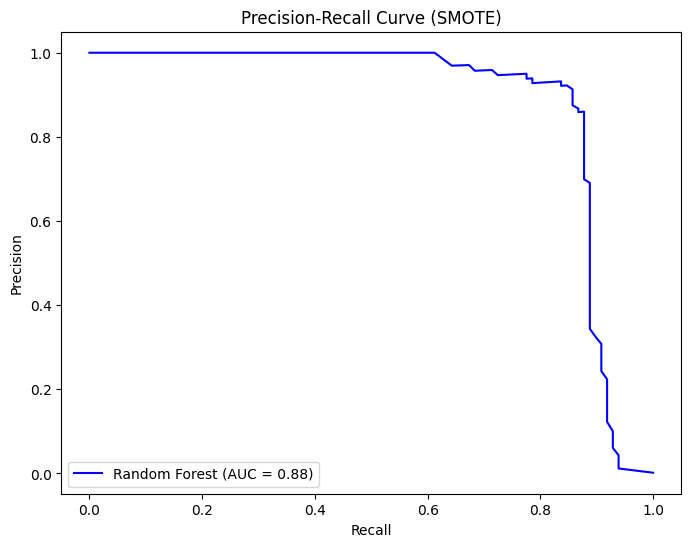

In [11]:
#Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SMOTE)')
plt.legend(loc='best')
plt.show()

In [12]:
#Generate classification report
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [13]:
#Check what features influence decision-making the most
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

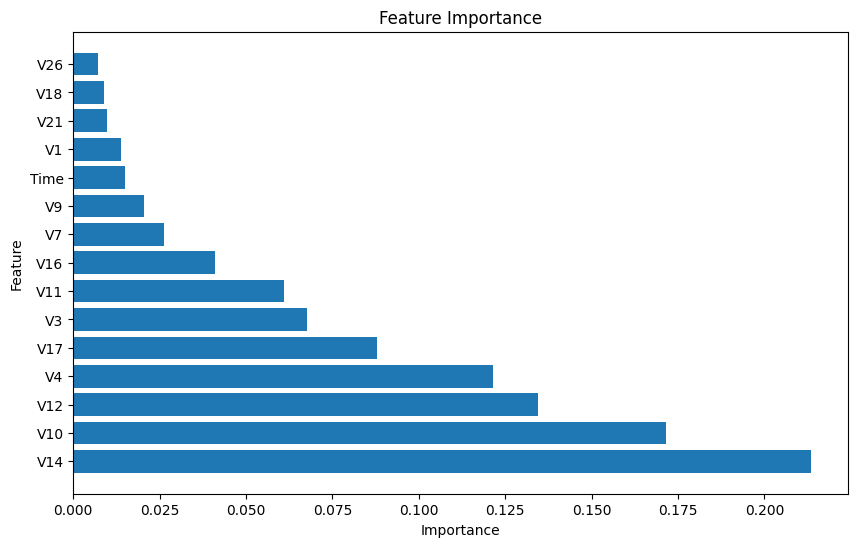

In [14]:
#Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()